# VectorDB for Images (Using FAISS)
In 2007, Apple did a miraculous thing, and started putting cameras in people's pockets. Since then, the quantity of image data has increased exponentially across the internet. Everyone is putting images on their social media; clicking pictures of everything from their pets to the food that they ate.

What the problem becomes now, is how to sort through all that data?
For text, it is easier. Ctrl+F allows you to search 1000 page PDFs with keywords, or even perform similarity search on a rather large corpora of data within minutes.

But images, they not only carry memories, they also carry high dimensional data. Most modern images go anywhere from 100+ KB to a few MBs per image. Compared to that, a PDF that holds 2500+ words with additional formatting and graphics go for ~500KB (a picture really is worth more than a thousand words...).


**So what to do? how to look for similar images?**

Well, we do some ✨magic✨

## Vector Databases and Images
So you have decided to store the images in a vector database for easy similarity search and retrieval. What does it mean? what is a vectorDB and how does the similarity search work better than just looking through the images one-by-one in the most humanly slow way possible?

First of all, are you serious? One-by-one? You should go to the nearest Gen-Z for tech re-education.

Second, It is **easy**!

**High-Level Flow:**
1. Data Preparation

    * Load images from a specified folder.
    * Compute embeddings for each image.
    * Store embeddings in a FAISS index.

2. Query Processing

    * Accept either an image or a text query.
    * Compute the embedding for the query.
    * Search for the closest matches in the FAISS index.

3. Results Display
    * Retrieve the top-k matching images.
    * Display them using matplotlib.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install faiss-cpu

## Generating The Embeddings

## FAISS Index Building

In [3]:
def build_faiss_index(image_folder):
    """Build FAISS index from images in a folder."""
    image_files = glob.glob(os.path.join(image_folder, "*"))
    embeddings, metadata = [], []

    for file in image_files:
        emb = get_image_embedding(file)
        if emb is not None:
            embeddings.append(emb)
            metadata.append(file)

    if not embeddings:
        print("No images were processed.")
        return None, None

    embeddings = np.vstack(embeddings).astype(np.float32)
    faiss.normalize_L2(embeddings)
    d = embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(embeddings)
    print(f"Built FAISS index with {index.ntotal} vectors of dimension {d}.")
    return index, metadata

## Query Functions

In [4]:
def query_faiss(index, metadata, query, k=5, query_type="image"):
    """Perform a query using FAISS."""
    query_emb = get_image_embedding(query) if query_type == "image" else get_text_embedding(query)
    query_emb = np.array(query_emb, dtype=np.float32).reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, k)
    return [metadata[i] for i in indices[0]], distances[0]

def query_by_text(index, metadata, text_query, k=5):
    """Query FAISS index using text."""
    return query_faiss(index, metadata, text_query, k, query_type="text")

def query_by_image(index, metadata, image_path, k=5):
    """Query FAISS index using an image."""
    return query_faiss(index, metadata, image_path, k, query_type="image")


## Displaying the results

In [5]:
def display_results(image_paths, scores, k=5):
    """Display top-k images from query results."""
    fig, axes = plt.subplots(1, k, figsize=(20, 5))
    for i, (image_path, score) in enumerate(zip(image_paths[:k], scores[:k])):
        image = Image.open(image_path).convert("RGB")
        axes[i].imshow(image)
        axes[i].set_title(f"Score: {score:.4f}")
        axes[i].axis('off')
    plt.show()



## The exciting part!!!

In [6]:
if __name__ == "__main__":
    image_folder = "/kaggle/input/stanforddogs-15percat/dogsinone"
    index, metadata = build_faiss_index(image_folder)
    if index is None:
        exit("Index building failed. Ensure your image folder is correct and non-empty.")

Built FAISS index with 1800 vectors of dimension 512.



Results for text query:
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02100735-English_setter_n02100735_10201.jpg, similarity score: 0.3321
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02101388-Brittany_spaniel_n02101388_1050.jpg, similarity score: 0.3262
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02111500-Great_Pyrenees_n02111500_1097.jpg, similarity score: 0.3153
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02105641-Old_English_sheepdog_n02105641_10280.jpg, similarity score: 0.3141
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02106166-Border_collie_n02106166_1205.jpg, similarity score: 0.3083


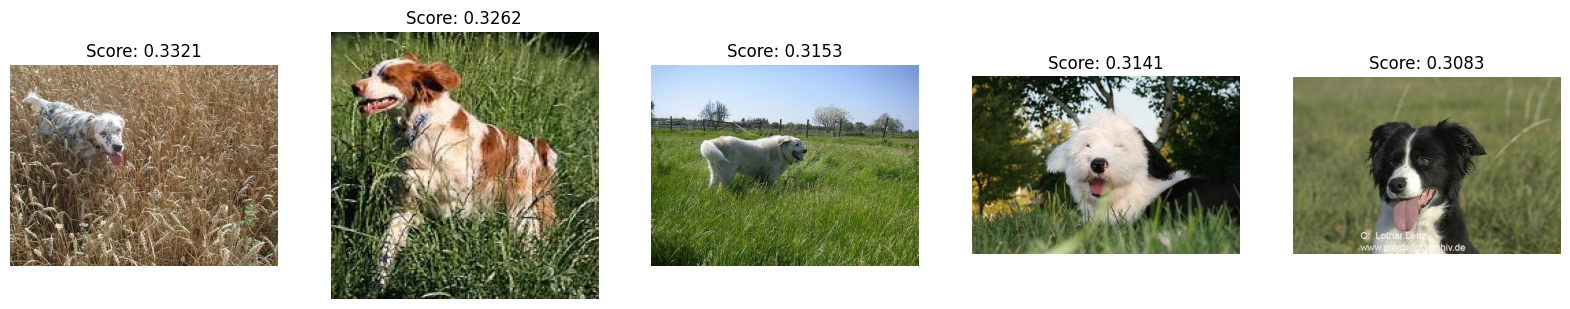

In [9]:
    # Query by text
    text_query = "dog laughing in a field"
    results_text, scores_text = query_by_text(index, metadata, text_query, k=5)
    print("\nResults for text query:")
    for res, score in zip(results_text, scores_text):
        print(f"Image: {res}, similarity score: {score:.4f}")
    display_results(results_text, scores_text)


Results for image query:
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02085620-Chihuahua_n02085620_11477.jpg, similarity score: 1.0000
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02086646-Blenheim_spaniel_n02086646_118.jpg, similarity score: 0.7346
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02087046-toy_terrier_n02087046_1386.jpg, similarity score: 0.7294
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02087046-toy_terrier_n02087046_1520.jpg, similarity score: 0.7237
Image: /kaggle/input/stanforddogs-15percat/dogsinone/n02096585-Boston_bull_n02096585_10734.jpg, similarity score: 0.7206


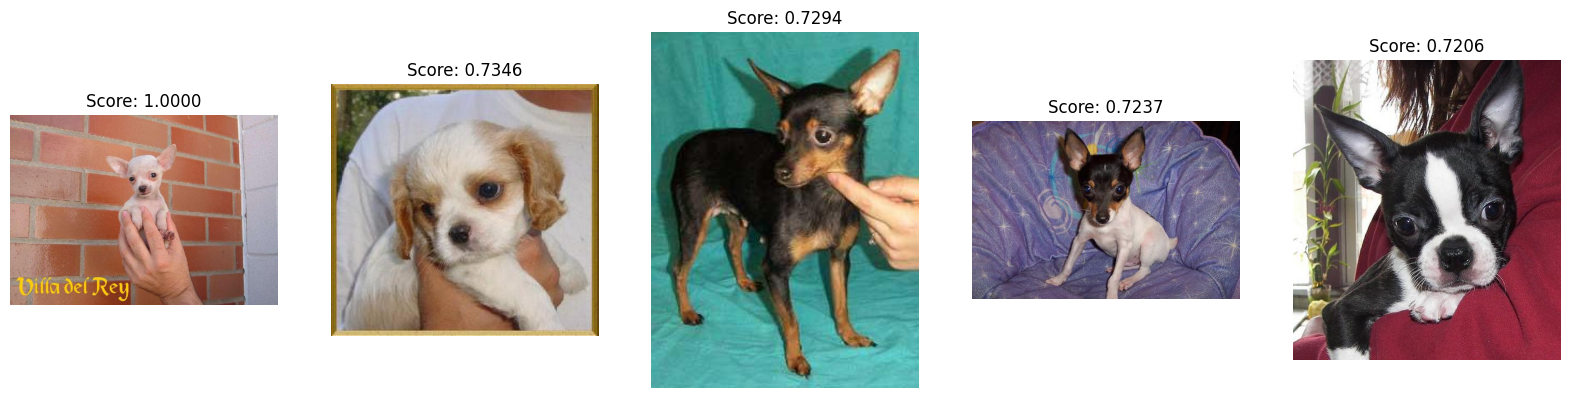

In [8]:
    # Query by image
    image_query = "/kaggle/input/stanforddogs-15percat/dogsinone/n02085620-Chihuahua_n02085620_11477.jpg"
    results_image, scores_image = query_by_image(index, metadata, image_query, k=5)
    print("\nResults for image query:")
    for res, score in zip(results_image, scores_image):
        print(f"Image: {res}, similarity score: {score:.4f}")
    display_results(results_image, scores_image)